# Spotify Song Data - Data Cleaning

This is the data cleaning notebook for a classification project that uses a dataset of Spotify song data to determine what features make a song popular on the platform, aka a hit song.

## Introduction

### Imports

In [1]:
# Regulars
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


Bad key "text.kerning_factor" on line 4 in
/Users/spags/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
# tqdm
# %%capture
from tqdm import tqdm_notebook as tqdm
tqdm().pandas()

/Users/spags/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


0it [00:00, ?it/s]

### Functions

In [3]:
def get_info(df):
    '''Simple function that takes in a full dataframe and returns
    some basic information about the countents of the dataframe.'''
    
    print('Shape of DataFrame:\n', df.shape)
    print('\nDataFrame Info:')
    print(df.info())
    print('\n Null Values Present:\n', df.isna().sum())

## Obtain

### Import Dataset

In [4]:
df = pd.read_csv('spotify_song_data.csv')
print(df.shape)
df.head()

(174389, 19)


,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year
0,0.991000,['Mamie Smith'],0.598,168333,0.224,0,0cS0A1fUEUd1EW3FcF8AEI,0.000522,5,0.3790,-12.628,0,Keep A Song In Your Soul,12,1920,0.0936,149.976,0.6340,1920
1,0.643000,"[""Screamin' Jay Hawkins""]",0.852,150200,0.517,0,0hbkKFIJm7Z05H8Zl9w30f,0.026400,5,0.0809,-7.261,0,I Put A Spell On You,7,1920-01-05,0.0534,86.889,0.9500,1920
2,0.993000,['Mamie Smith'],0.647,163827,0.186,0,11m7laMUgmOKqI3oYzuhne,0.000018,0,0.5190,-12.098,1,Golfing Papa,4,1920,0.1740,97.600,0.6890,1920
3,0.000173,['Oscar Velazquez'],0.730,422087,0.798,0,19Lc5SfJJ5O1oaxY0fpwfh,0.801000,2,0.1280,-7.311,1,True House Music - Xavier Santos & Carlos Gomi...,17,1920-01-01,0.0425,127.997,0.0422,1920
4,0.295000,['Mixe'],0.704,165224,0.707,1,2hJjbsLCytGsnAHfdsLejp,0.000246,10,0.4020,-6.036,0,Xuniverxe,2,1920-10-01,0.0768,122.076,0.2990,1920


## Data Cleaning

In [5]:
# Checking out some info
get_info(df)

Shape of DataFrame:
 (174389, 19)

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 174389 entries, 0 to 174388
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   acousticness      174389 non-null  float64
 1   artists           174389 non-null  object 
 2   danceability      174389 non-null  float64
 3   duration_ms       174389 non-null  int64  
 4   energy            174389 non-null  float64
 5   explicit          174389 non-null  int64  
 6   id                174389 non-null  object 
 7   instrumentalness  174389 non-null  float64
 8   key               174389 non-null  int64  
 9   liveness          174389 non-null  float64
 10  loudness          174389 non-null  float64
 11  mode              174389 non-null  int64  
 12  name              174389 non-null  object 
 13  popularity        174389 non-null  int64  
 14  release_date      174389 non-null  object 
 15  speechiness      

### Name

Let's set the song name as the index for the dataframe

In [6]:
df.set_index('name', inplace = True)
df.head()

,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,popularity,release_date,speechiness,tempo,valence,year
name,,,,,,,,,,,,,,,,,,
Keep A Song In Your Soul,0.991000,['Mamie Smith'],0.598,168333,0.224,0,0cS0A1fUEUd1EW3FcF8AEI,0.000522,5,0.3790,-12.628,0,12,1920,0.0936,149.976,0.6340,1920
I Put A Spell On You,0.643000,"[""Screamin' Jay Hawkins""]",0.852,150200,0.517,0,0hbkKFIJm7Z05H8Zl9w30f,0.026400,5,0.0809,-7.261,0,7,1920-01-05,0.0534,86.889,0.9500,1920
Golfing Papa,0.993000,['Mamie Smith'],0.647,163827,0.186,0,11m7laMUgmOKqI3oYzuhne,0.000018,0,0.5190,-12.098,1,4,1920,0.1740,97.600,0.6890,1920
True House Music - Xavier Santos & Carlos Gomix Remix,0.000173,['Oscar Velazquez'],0.730,422087,0.798,0,19Lc5SfJJ5O1oaxY0fpwfh,0.801000,2,0.1280,-7.311,1,17,1920-01-01,0.0425,127.997,0.0422,1920
Xuniverxe,0.295000,['Mixe'],0.704,165224,0.707,1,2hJjbsLCytGsnAHfdsLejp,0.000246,10,0.4020,-6.036,0,2,1920-10-01,0.0768,122.076,0.2990,1920


### ID

I suppose we can drop the ID column as it's not really necessary for this project at the moment.

In [7]:
df.drop('id', axis = 1, inplace = True)
df.head()

,acousticness,artists,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,release_date,speechiness,tempo,valence,year
name,,,,,,,,,,,,,,,,,
Keep A Song In Your Soul,0.991000,['Mamie Smith'],0.598,168333,0.224,0,0.000522,5,0.3790,-12.628,0,12,1920,0.0936,149.976,0.6340,1920
I Put A Spell On You,0.643000,"[""Screamin' Jay Hawkins""]",0.852,150200,0.517,0,0.026400,5,0.0809,-7.261,0,7,1920-01-05,0.0534,86.889,0.9500,1920
Golfing Papa,0.993000,['Mamie Smith'],0.647,163827,0.186,0,0.000018,0,0.5190,-12.098,1,4,1920,0.1740,97.600,0.6890,1920
True House Music - Xavier Santos & Carlos Gomix Remix,0.000173,['Oscar Velazquez'],0.730,422087,0.798,0,0.801000,2,0.1280,-7.311,1,17,1920-01-01,0.0425,127.997,0.0422,1920
Xuniverxe,0.295000,['Mixe'],0.704,165224,0.707,1,0.000246,10,0.4020,-6.036,0,2,1920-10-01,0.0768,122.076,0.2990,1920


### Null Values

In [8]:
# Checking nulls 
df.isna().sum()

acousticness        0
artists             0
danceability        0
duration_ms         0
energy              0
explicit            0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
popularity          0
release_date        0
speechiness         0
tempo               0
valence             0
year                0
dtype: int64

No nulls here, so we're in the clear!

### Year

Let's try a different approach here. At first, we changed the values of the year column to strings so that they wouldn't be affected by scaling. The drawback here is that we wound up with a massive amount of columns after one hot encoding it as a categorical column. Let's try binning year into decades to cut down on these columns.

In [9]:
df['year'].unique()

array([1920, 1921, 1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929, 1930,
       1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941,
       1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952,
       1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963,
       1964, 1965, 1966, 1968, 2008, 2018, 2020, 1997, 1991, 2006, 2012,
       2011, 2007, 1967, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976,
       1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987,
       1988, 1989, 1990, 1992, 1993, 1994, 1995, 1996, 1998, 1999, 2000,
       2019, 2013, 2001, 2017, 2016, 2010, 2002, 2004, 2005, 2015, 2003,
       2009, 2021, 2014])

In [10]:
for i in tqdm(df['year']):
    if i >= 1920 and i < 1930:
        df['year'] = df['year'].replace(i, '1920s')
    elif i >= 1930 and i < 1940:
        df['year'] = df['year'].replace(i, '1930s')
    elif i >= 1940 and i < 1950:
        df['year'] = df['year'].replace(i, '1940s')
    elif i >= 1950 and i < 1960:
        df['year'] = df['year'].replace(i, '1950s')
    elif i >= 1960 and i < 1970:
        df['year'] = df['year'].replace(i, '1960s')
    elif i >= 1970 and i < 1980:
        df['year'] = df['year'].replace(i, '1970s')
    elif i >= 1980 and i < 1990:
        df['year'] = df['year'].replace(i, '1980s')
    elif i >= 1990 and i < 2000:
        df['year'] = df['year'].replace(i, '1990s')
    elif i >= 2000 and i < 2010:
        df['year'] = df['year'].replace(i, '2000s')
    elif i >= 2010 and i < 2020:
        df['year'] = df['year'].replace(i, '2010s')
    elif i >= 2020 and i < 2029:
        df['year'] = df['year'].replace(i, '2020s')

/Users/spags/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


  0%|          | 0/174389 [00:00<?, ?it/s]

In [11]:
df['year'].value_counts()

2010s    22455
1990s    20328
1970s    20118
1980s    20074
1950s    20000
1960s    19610
1940s    15493
2000s    13782
1930s    10764
2020s     6134
1920s     5631
Name: year, dtype: int64

### Release Date

Let's change the release date to a datetime object.

In [12]:
df['release_date'] = pd.to_datetime(df['release_date'])
df.head()

,acousticness,artists,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,release_date,speechiness,tempo,valence,year
name,,,,,,,,,,,,,,,,,
Keep A Song In Your Soul,0.991000,['Mamie Smith'],0.598,168333,0.224,0,0.000522,5,0.3790,-12.628,0,12,1920-01-01,0.0936,149.976,0.6340,1920s
I Put A Spell On You,0.643000,"[""Screamin' Jay Hawkins""]",0.852,150200,0.517,0,0.026400,5,0.0809,-7.261,0,7,1920-01-05,0.0534,86.889,0.9500,1920s
Golfing Papa,0.993000,['Mamie Smith'],0.647,163827,0.186,0,0.000018,0,0.5190,-12.098,1,4,1920-01-01,0.1740,97.600,0.6890,1920s
True House Music - Xavier Santos & Carlos Gomix Remix,0.000173,['Oscar Velazquez'],0.730,422087,0.798,0,0.801000,2,0.1280,-7.311,1,17,1920-01-01,0.0425,127.997,0.0422,1920s
Xuniverxe,0.295000,['Mixe'],0.704,165224,0.707,1,0.000246,10,0.4020,-6.036,0,2,1920-10-01,0.0768,122.076,0.2990,1920s


Since we already have our years binned into decades and one hot encoding the release date would ballooon our dataset, let's make this a bit more manageable by pulling the release month from the datetime object.

In [13]:
import datetime as dt

In [15]:
df['month'] = df['release_date'].dt.month

Now we can drop the release date column.

In [16]:
df.drop('release_date', axis = 1, inplace = True)

In [17]:
df.head()

,acousticness,artists,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,valence,year,month
name,,,,,,,,,,,,,,,,,
Keep A Song In Your Soul,0.991000,['Mamie Smith'],0.598,168333,0.224,0,0.000522,5,0.3790,-12.628,0,12,0.0936,149.976,0.6340,1920s,1
I Put A Spell On You,0.643000,"[""Screamin' Jay Hawkins""]",0.852,150200,0.517,0,0.026400,5,0.0809,-7.261,0,7,0.0534,86.889,0.9500,1920s,1
Golfing Papa,0.993000,['Mamie Smith'],0.647,163827,0.186,0,0.000018,0,0.5190,-12.098,1,4,0.1740,97.600,0.6890,1920s,1
True House Music - Xavier Santos & Carlos Gomix Remix,0.000173,['Oscar Velazquez'],0.730,422087,0.798,0,0.801000,2,0.1280,-7.311,1,17,0.0425,127.997,0.0422,1920s,1
Xuniverxe,0.295000,['Mixe'],0.704,165224,0.707,1,0.000246,10,0.4020,-6.036,0,2,0.0768,122.076,0.2990,1920s,10


### Artists

In [18]:
df['artists'].value_counts()

['Tadeusz Dolega Mostowicz']         1281
['Эрнест Хемингуэй']                 1175
['Эрих Мария Ремарк']                1062
['Francisco Canaro']                  951
['Ignacio Corsini']                   624
                                     ... 
['Abrasive Wheels']                     1
['Walter Bobbie', 'J.K. Simmons']       1
['Premlata', 'Mubarak Begum']           1
['María José']                          1
['Borneo & Sporenburg']                 1
Name: artists, Length: 36195, dtype: int64

Keeping all the artists in the artist column creates an issue when one hot encoding...namely that it expands to over 31k columns and creates an issue for running our models. Let's do some exploration here and see if there's any way to bin artists in a sensible way.

In [19]:
df['artists'].value_counts().unique().sum()

31331

Wow...31k+ unique artists represented in this dataset. This presents an interesting dilemma. It doesn't seem too likely that we can figure out a way to bin this column in a sensible way. We could separate the artists into bins of multiple artists and single artists for the tracks but that doesn't really take the individual artist popularity into account.

For now, we're going to have to dump the artist column and then revisit this down the line after being able to get a few successful models running.

In [20]:
df.drop('artists', axis = 1, inplace = True)

### Popularity Column

This one is going to take some thought and research. We know that the popularity metric is a number from 1 to 100 that (with 100 being the most popular) that is assigned to a song to denote it's popularity. Spotify calculates this metric based on total streams, trends, and several other factors. First, we need to see what we're working with in terms of the value counts. Next, we need to make some sort of determination of what level of popularity constitutes as a hit song and the level that constitutes a dud.

<b> Note:</b> In the other notebook, we work on a multiclass version that creates 3 targets: hit, solid single, and dud.

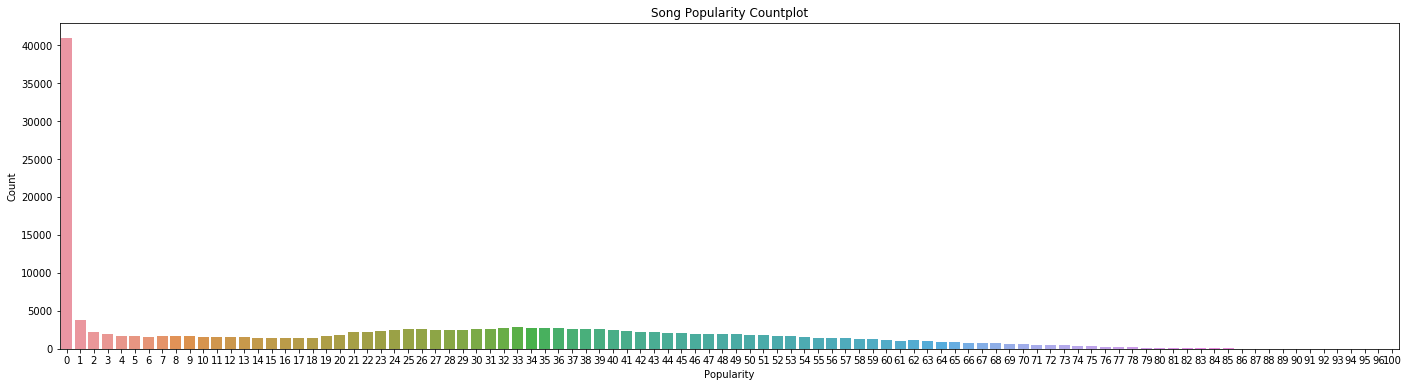

In [21]:
# Placeholder Plot

ax = plt.figure(figsize = (24, 6))
ax = sns.countplot(df['popularity'])
ax.set_title('Song Popularity Countplot')
ax.set_xlabel('Popularity')
ax.set_ylabel('Count')
plt.show();

> We can see from the figure above that an overhwelmingly large percentage of the songs have a popularity of 0 and the top of the scale is an extremely small percentage.  This is going to wreak havok on class weights.

<b>From Spotify:</b><br>
The popularity of the track. The value will be between 0 and 100, with 100 being the most popular. The popularity of a track is a value between 0 and 100, with 100 being the most popular. The popularity is calculated by algorithm and is based, in the most part, on the total number of plays the track has had and how recent those plays are. Generally speaking, songs that are being played a lot now will have a higher popularity than songs that were played a lot in the past. Duplicate tracks (e.g. the same track from a single and an album) are rated independently. Artist and album popularity is derived mathematically from track popularity. Note that the popularity value may lag actual popularity by a few days: the value is not updated in real time.

#### Binning Popularity

We'll make the following labels by binning hte popularity metric:<br>
0 - Not a hit<br>
1 - Hit

In [22]:
# Using the following code with various values to check what our thresholds should be

df[df["popularity"] == 65]

,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,valence,year,month
name,,,,,,,,,,,,,,,,
Rudolph the Red-Nosed Reindeer,0.88300,0.629,186733,0.1590,0,0.000000,8,0.2220,-14.056,1,65,0.0495,142.157,0.642,1940s,1
I Fall In Love Too Easily - Vocal Version,0.94000,0.532,201440,0.0657,0,0.004880,0,0.0946,-19.136,0,65,0.0406,128.607,0.292,1950s,1
Pennies From Heaven,0.45200,0.515,141667,0.4080,0,0.000000,8,0.0682,-11.960,1,65,0.1940,185.767,0.915,1950s,1
I'll Be Seeing You,0.98900,0.355,211533,0.0304,0,0.055500,1,0.1160,-20.479,1,65,0.0361,90.495,0.188,1950s,1
Volare (Nel Blu Di Pinto Di Blu) - Remastered,0.88000,0.612,181627,0.1440,0,0.000000,6,0.2030,-12.204,0,65,0.0352,128.629,0.343,1950s,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Legacy (feat. Travis Scott & 21 Savage),0.17800,0.844,244941,0.5130,1,0.000000,1,0.0845,-8.769,1,65,0.3350,128.085,0.344,2010s,2
NNAN,0.28100,0.817,193479,0.5390,1,0.000000,5,0.1990,-5.015,1,65,0.0626,96.039,0.674,2010s,9
VALENTINO,0.19700,0.744,179133,0.7180,1,0.000000,9,0.1340,-4.853,0,65,0.1810,151.098,0.549,2010s,1


> First we'll create strings and then label encode from there.  I'm sure there's an easier way, but this is what's worked for me to this point.

In [23]:
for i in tqdm(df['popularity']):
    if i >= 65:
        df['popularity'] = df['popularity'].replace(i, 'Hit')
    else:
        df['popularity'] = df['popularity'].replace(i, 'Dud')

/Users/spags/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


  0%|          | 0/174389 [00:00<?, ?it/s]

In [24]:
df['popularity'].value_counts()

Dud    166417
Hit      7972
Name: popularity, dtype: int64

In [25]:
# Now for encoding it for 1 and 0

for i in tqdm(df['popularity']):
    if i == 'Hit':
        df['popularity'] = df['popularity'].replace(i, 1)
    else: 
        df['popularity'] = df['popularity'].replace(i, 0)

/Users/spags/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


  0%|          | 0/174389 [00:00<?, ?it/s]

In [26]:
df['popularity'].value_counts()

0    166417
1      7972
Name: popularity, dtype: int64

## Save Clean DataFrame

In [27]:
df.head()

,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,valence,year,month
name,,,,,,,,,,,,,,,,
Keep A Song In Your Soul,0.991000,0.598,168333,0.224,0,0.000522,5,0.3790,-12.628,0,0,0.0936,149.976,0.6340,1920s,1
I Put A Spell On You,0.643000,0.852,150200,0.517,0,0.026400,5,0.0809,-7.261,0,0,0.0534,86.889,0.9500,1920s,1
Golfing Papa,0.993000,0.647,163827,0.186,0,0.000018,0,0.5190,-12.098,1,0,0.1740,97.600,0.6890,1920s,1
True House Music - Xavier Santos & Carlos Gomix Remix,0.000173,0.730,422087,0.798,0,0.801000,2,0.1280,-7.311,1,0,0.0425,127.997,0.0422,1920s,1
Xuniverxe,0.295000,0.704,165224,0.707,1,0.000246,10,0.4020,-6.036,0,0,0.0768,122.076,0.2990,1920s,10


Now that we've successfully cleaned the data, we can save our clean dataframe to use in other notebooks.  

In [28]:
df.to_csv('clean_spotify_data.csv')